In [113]:
using Lux, Flux, Zygote, ForwardDiff, Optimization
using Random, ComponentArrays, LinearAlgebra

struct LagrangianNN{M <: Lux.AbstractExplicitLayer} <: Lux.AbstractExplicitContainerLayer{(:model,)}
    model::M
    ad
end


function LagrangianNN(model)
    !(model isa Lux.AbstractExplicitLayer) && (model = Lux.transform(model))
    return LagrangianNN(model, Optimization.AutoZygote())
end

function (lnn::LagrangianNN{<: Lux.AbstractExplicitLayer})(state, ps, st)
    model = Lux.StatefulLuxLayer(lnn.model, nothing, st)

    q, qdot = (state[1, :], state[2, :])
    to_state(q, qdot) = reshape(hcat(q, qdot), 2, :)
    L(q, qdot, ps) = sum(first(model(to_state(q, qdot), ps)))
    dLdqdot(q) = ForwardDiff.gradient(qdot_ -> L(q, qdot_, ps), qdot)
    
    dLdq = ForwardDiff.gradient(q_ -> L(q_, qdot, ps), q)
    d_dLdqdot_dq = ForwardDiff.jacobian(q_ -> dLdqdot(q_), q)  
    H = ForwardDiff.hessian(qdot_ -> L(q, qdot_, ps), qdot) + 1.0e-3 * I

    qddot = H \ (dLdq - d_dLdqdot_dq * qdot)
    return to_state(qdot, qddot), model.st
end


lnn = LagrangianNN(Flux.Chain(Flux.Dense(2 => 16, tanh), Flux.Dense(16 => 1)))
ps, st = Lux.setup(Random.default_rng(), lnn)
ps = ps |> ComponentArray

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.05358039 0.42885178; 0.40714902 0.53597295; … ; 0.39075658 -0.07513255; -0.55468595 0.43117958], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.16618805 -0.4912402 … -0.47316334 0.2863256], bias = Float32[0.0;;]))

(2, 64)
loss 312574.150174729


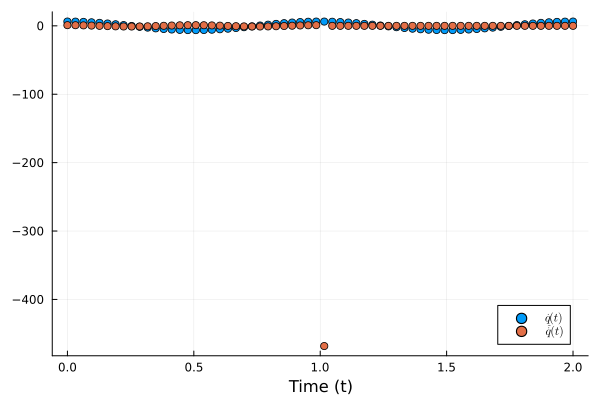

In [114]:
using Plots, LaTeXStrings

π_32 = Float32(π)
tspan = (0.0f0, 2.0f0)
tsteps = range(tspan[1], tspan[2]; length = 64)

q_t = reshape(sin.(2π_32 * tsteps), 1, :)
p_t = reshape(cos.(2π_32 * tsteps), 1, :)
data = vcat(q_t, p_t)

dqdt = 2π_32 .* p_t
dpdt = -2π_32 .* q_t
target = vcat(dqdt, dpdt)

println(size(first(lnn(data, ps, st))))


function loss_function(ps, data, target)
    pred, _ = lnn(data, ps, st)
    return sum(abs2, pred .- target), pred
end

l, pred = loss_function(ps, data, target)
println("loss ", l)

plt = scatter(tsteps, target[1, :], label=L"\dot{q}(t)")
scatter!(plt, tsteps, pred[1, :], label=L"\hat{\dot{q}}(t)")
xlabel!("Time (t)")
display(plot(plt))

In [115]:
using OptimizationOptimisers

opt = OptimizationOptimisers.Adam(0.01f0)
opt_func = Optimization.OptimizationFunction((u, p) -> loss_function(u, data, target), Optimization.AutoForwardDiff())
opt_prob = Optimization.OptimizationProblem(opt_func, ps)

callback = function (ps, loss, pred)
    println("[Lagrangian NN] Loss: ", loss)
    return false
end

opt_res = Optimization.solve(opt_prob, opt; callback, maxiters = 300)

ps_trained = opt_res.u
final_loss, pred = loss_function(ps_trained, data, target)

plt = scatter(tsteps, target[1, :], label=L"q(t)")
scatter!(plt, tsteps, pred[1, :], label=L"\hat{q}(t)")
xlabel!("Time (t)")
display(plot(plt))

#iteration: 1

┌ Warning: `ForwardDiff.gradient(f, x)` within Zygote cannot track gradients with respect to `f`,
│ and `f` appears to be a closure, or a struct with fields (according to `issingletontype(typeof(f))`).
│ typeof(f) = var"#632#639"{ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = ViewAxis(1:48, Axis(weight = ViewAxis(1:32, ShapedAxis((16, 2))), bias = ViewAxis(33:48, ShapedAxis((16, 1))))), layer_2 = ViewAxis(49:65, Axis(weight = ViewAxis(1:16, ShapedAxis((1, 16))), bias = ViewAxis(17:17, ShapedAxis((1, 1))))))}}}, var"#L#636"{var"#to_state#635", StatefulLuxLayer{true, Lux.Chain{@NamedTuple{layer_1::Lux.Dense{true, typeof(tanh_fast), typeof(glorot_uniform), typeof(WeightInitializers.zeros32)}, layer_2::Lux.Dense{true, typeof(identity), typeof(glorot_uniform), typeof(WeightInitializers.zeros32)}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}}}}, Vector{Float32}}
└ @ Zygote /home/mrrobot/.julia/packages/Zygote/jxHJc/src/lib/forward.jl:142
┌ W

MethodError: MethodError: no method matching zero(::Type{ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = ViewAxis(1:48, Axis(weight = ViewAxis(1:32, ShapedAxis((16, 2))), bias = ViewAxis(33:48, ShapedAxis((16, 1))))), layer_2 = ViewAxis(49:65, Axis(weight = ViewAxis(1:16, ShapedAxis((1, 16))), bias = ViewAxis(17:17, ShapedAxis((1, 1))))))}}}})

Closest candidates are:
  zero(!Matched::Type{Union{}}, Any...)
   @ Base number.jl:310
  zero(!Matched::Type{Dates.Time})
   @ Dates ~/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/Dates/src/types.jl:440
  zero(!Matched::Type{LibGit2.GitHash})
   @ LibGit2 ~/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/LibGit2/src/oid.jl:221
  ...
